In [1]:
%matplotlib inline

import cv2
import numpy as np
import pytesseract
from matplotlib import pyplot as plt
import imutils

In [2]:
def img_show(name,img):
    cv2.imshow(name, img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    cv2.waitKey(1)

In [20]:
cub = "./receipts/traderjoes.jpg"
costco = "./receipts/costco.jpg"

In [21]:
img = cv2.imread(costco)
orig = img.copy()

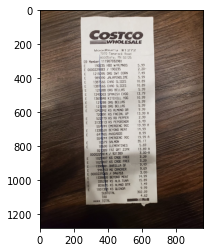

In [23]:
plt.imshow(imutils.opencv2matplotlib(img))

In [24]:
# cv2.imshow('cub_receipt', cubpic)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [25]:
#-----Reading the image-----------------------------------------------------
# cv2.imshow("img",img)
img.shape

(1280, 960, 3)

In [26]:
# Crop the image to remove edges
y = 0
h = 1280
x = 200
w = 720
crop_img = img[y:h,x:w]
img_show("cropped", crop_img)

## Identify the edges

In [27]:
# convert to gray scale, removes color noise
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_show("gray", gray)

In [28]:
# blur the image to remove high frequency noise 
# it helps in finding/detecting contour in gray image
grayImageBlur = cv2.blur(gray,(3,3))
img_show("grayblur", grayImageBlur)

In [29]:
# then we performed canny edge detection
edgedImage = cv2.Canny(grayImageBlur,10,150, 3)
img_show("edged", edgedImage)

In [30]:
# auto canny function from imutils - Doesn't seem to work too well
edgeMap = imutils.auto_canny(gray)
# cv2.imshow("Original", img)
# cv2.imshow("Manual Edge Map", edgedImage)
# cv2.imshow("Automatic Edge Map", edgeMap)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

## Detect receipt edges

In [31]:
# find the contours in the edged image, sort area wise keeping only the largest ones 
allContours = cv2.findContours(edgedImage.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
allContours = imutils.grab_contours(allContours)

len(allContours)
allContours_array = np.array(allContours)
#print(allContours_array)

In [32]:
# descending sort contours area and keep top 1
allContours = sorted(allContours, key=cv2.contourArea, reverse=True)[:1]
# print(allContours)

In [33]:
# show the contour on image
# for conts in allContours:
# approximate the contour
perimeter = cv2.arcLength(allContours[0], True) 
ROIdimensions = cv2.approxPolyDP(allContours[0], 0.02*perimeter, True)

cv2.drawContours(img, [ROIdimensions], -1, (0,255,0), 2)
img_show("Contour Outline", img)

## Identify & Extract Document Boundary Edges

In [34]:
# reshape coordinates array
ROIdimensions = ROIdimensions.reshape(4,2)

# list to hold ROI coordinates
rect = np.zeros((4,2), dtype="float32")

# top left corner will have the smallest sum, 
# bottom right corner will have the largest sum
s = np.sum(ROIdimensions, axis=1)
rect[0] = ROIdimensions[np.argmin(s)]
rect[2] = ROIdimensions[np.argmax(s)]
                
# top-right will have smallest difference
# botton left will have largest difference
diff = np.diff(ROIdimensions, axis=1)
rect[1] = ROIdimensions[np.argmin(diff)]
rect[3] = ROIdimensions[np.argmax(diff)]
                
# top-left, top-right, bottom-right, bottom-left
(tl, tr, br, bl) = rect
                
# compute width of ROI
widthA = np.sqrt((tl[0] - tr[0])**2 + (tl[1] - tr[1])**2 )
widthB = np.sqrt((bl[0] - br[0])**2 + (bl[1] - br[1])**2 )
maxWidth = max(int(widthA), int(widthB))
                
# compute height of ROI
heightA = np.sqrt((tl[0] - bl[0])**2 + (tl[1] - bl[1])**2 )
heightB = np.sqrt((tr[0] - br[0])**2 + (tr[1] - br[1])**2 )
maxHeight = max(int(heightA), int(heightB))

## Step 5: Apply perspective transform:

In [35]:
# Set of destinations points for "birds eye view"
# dimension of the new image
dst = np.array([
    [0,0],
    [maxWidth-1, 0],
    [maxWidth-1, maxHeight-1],
    [0, maxHeight-1]], dtype="float32")
# compute the perspective transform matrix and then apply it
transformMatrix = cv2.getPerspectiveTransform(rect, dst)
# transform ROI
scan = cv2.warpPerspective(orig, transformMatrix, (maxWidth, maxHeight))

img_show("Scanned", scan)

## Final Step

In [36]:
# convert to gray
scanGray = cv2.cvtColor(scan, cv2.COLOR_BGR2GRAY)
# display final gray image
cv2.imshow("scanGray", scanGray)
cv2.waitKey(0)
cv2.destroyAllWindows()
# ------------------------------
# convert to black/white with high contrast for documents
from skimage.filters import threshold_local
# increase contrast incase its document
T = threshold_local(scanGray, 9, offset=8, method="gaussian")
scanBW = (scanGray > T).astype("uint8") * 255

img_show("Final", scanBW)

## Read Text

In [37]:
text = pytesseract.image_to_string(scanBW)
print(text)

GOSTKED

SS WHOLESALE

Woodbury #1272

7070 Tamarack Road
jloodbury, MN 55125
G9 Menber} 11190703298
—  190R36 HBO W/ALMNDS
E 0000229883 / 190235
1215)95 ORG SWT CORN
gesp90 JALAPENCLIME
138766 CHAO SLICES
1367666 CHA SLICES
121b88 ORG BELLAS
124903 SPANISH EVOO
1369848 KITEHILL YOG
121p88 ORG BELLAS
121288 ORG BELLAS
1244842 KS ALMOND OR
720891 KS. FACIAL UP
S2dr79 KS RD PEPPER
3133113 KS PEPGRINDR
554244 ENERGENC: 90C
1336620 BEYOND HEAT
647165 AVOCADOS
554p44 EMERGENC 90C
10579 SALMON

  

mmamoammammm

mm mm

mm
Q
3S
2
e
a
=
mn
z
=
a
z
ma
a

g2'f89 FRZ ORT ZIPR
0000229414 / 921389
— 1024407 KS CAGE FREE
— 1029407 KS CAGE FREE
E 139061 BARTLLA “GF
E 946453 4G CRACKER
E 0000229265 / ‘946753
E 1338620 BEYOND NEAT
— 335288 KS ALB.TUNA
E 859695 KS ALMND BTR
E

 

TAX
